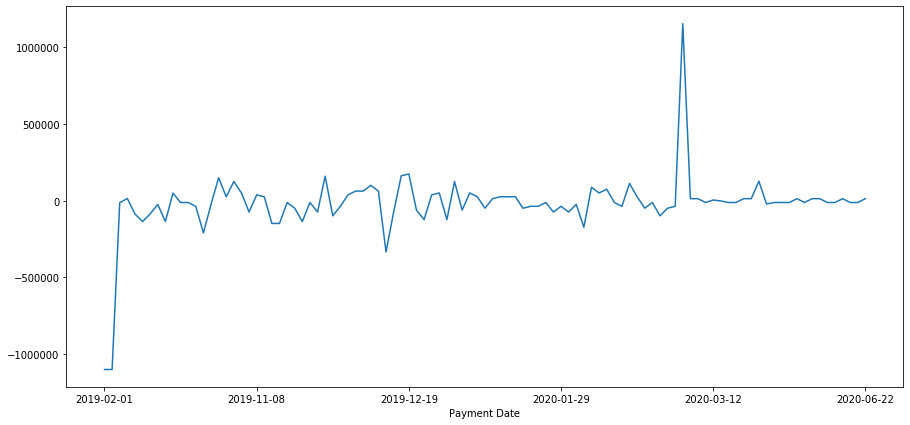

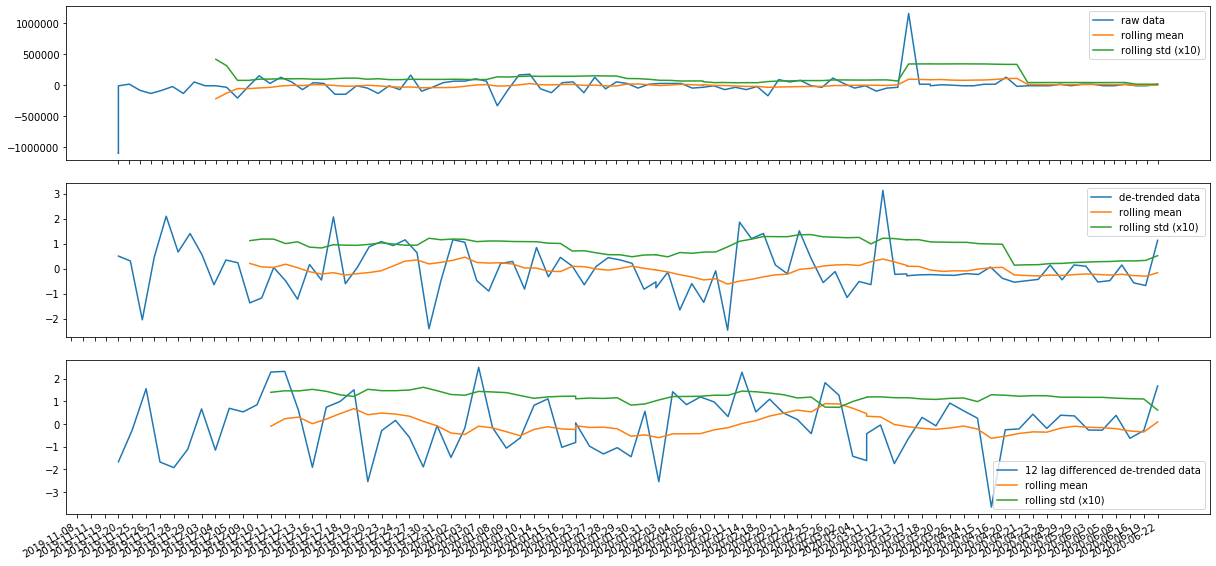

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
#plt.style.use('Solarize_Light2')


df = pd.read_csv(r'G:/temp/processed_data.csv').set_index('Payment Date')
df = df[df['Client Name']=='barclays'][:500]
train = df.iloc[:-10, :]
test = df.iloc[-10:, :]
pred = test.copy()
df['Paid Amount'].plot(figsize=(15,7));
#plt.title(jobj[0]['title']);

df['z_data'] = (df['Paid Amount'] - df['Paid Amount'].rolling(window=12).mean()) / df['Paid Amount'].rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(17, 9))
    ax[0].plot(df.index, df['Paid Amount'], label='raw data')
    ax[0].plot(df['Paid Amount'].rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df['Paid Amount'].rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    plt.show()
plot_rolling(df)

In [2]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df['Paid Amount'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = -8.804
P-value = 0.000
Critical values :
	1%: -3.497501033 - The data is  stationary with 99% confidence
	5%: -2.89090644 - The data is  stationary with 95% confidence
	10%: -2.5824349 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -8.579
P-value = 0.000
Critical values :
	1%: -3.506057133647011 - The data is  stationary with 99% confidence
	5%: -2.8946066061911946 - The data is  stationary with 95% confidence
	10%: -2.5844100201994697 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -4.190
P-value = 0.001
Critical values :
	1%: -3.5335601309235605 - The data is  stationary with 99% confidence
	5%: -2.9064436883991434 - The data is  stationary with 95% confidence
	10%: -2.590723948576676 - The data is  stationary with 90% confidence


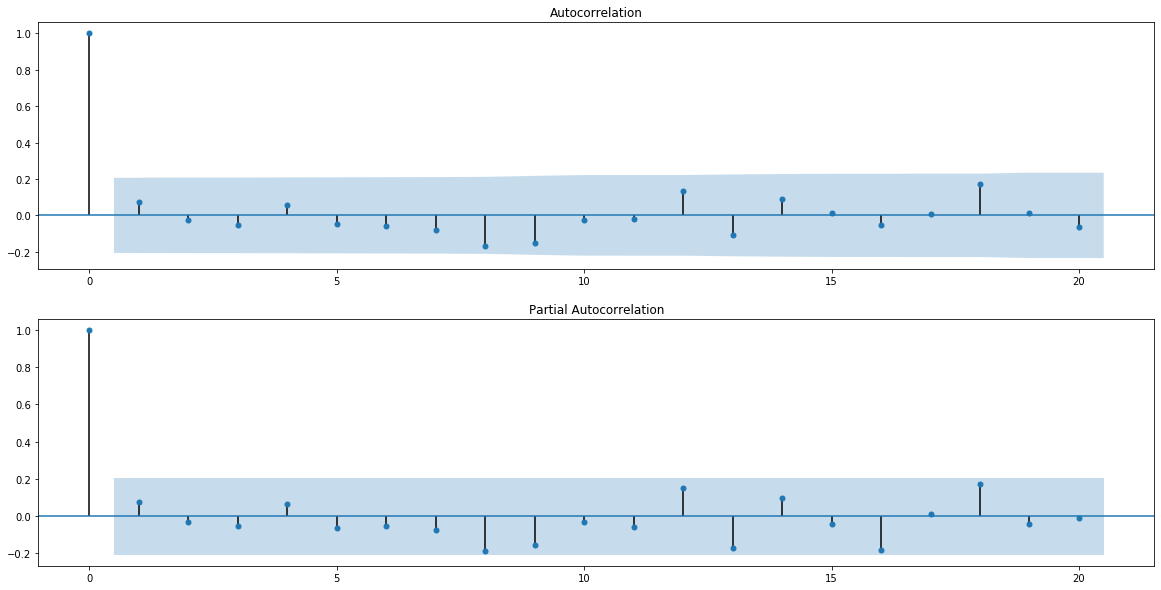

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(20,10))
ax[0] = plot_acf(df.z_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.z_data.dropna(), ax=ax[1], lags=20)

**NO LAGS**

C:\Users\OINDREELA\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\OINDREELA\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


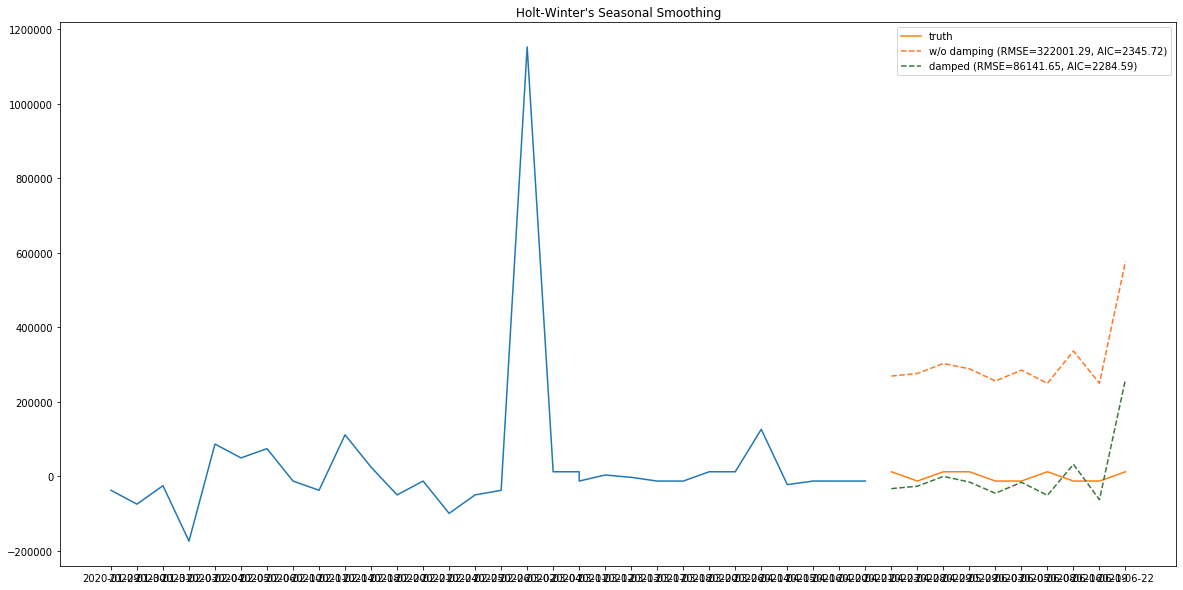

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

model = ExponentialSmoothing(np.asarray(train['Paid Amount']), trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(np.asarray(train['Paid Amount']), trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(len(test))
fit2 = model2.fit()
pred2 = fit2.forecast(len(test))

sse1 = np.sqrt(np.mean(np.square(test['Paid Amount'].values - pred)))
sse2 = np.sqrt(np.mean(np.square(test['Paid Amount'].values - pred2)))

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(train.index[60:], train['Paid Amount'].values[60:]);
ax.plot(test.index, test['Paid Amount'].values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

Damped gives better results